In [1]:
!dir

 Volume in drive C is Windows-SSD
 Volume Serial Number is 48AB-B2FD

 Directory of C:\Users\mihir\Desktop\Mini Project 2

11/12/2022  09:22 AM    <DIR>          .
11/12/2022  09:22 AM    <DIR>          ..
11/12/2022  09:22 AM    <DIR>          .ipynb_checkpoints
11/12/2022  08:57 AM            22,985 Mini_project_Submission_Instructions.docx
11/12/2022  09:22 AM                72 Untitled.ipynb
11/12/2022  08:57 AM         5,793,735 XYZ_Bank_Deposit_Data_Classification.csv
               3 File(s)      5,816,792 bytes
               3 Dir(s)  47,677,968,384 bytes free


In [2]:
import findspark
findspark.init()

In [322]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("week4")\
.getOrCreate()
sc=spark.sparkContext
sqlContext=SQLContext(sc)

C:\apps\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [323]:
df = spark.read.options(header = 'True',inferSchema='True',delimiter=';').csv("XYZ_Bank_Deposit_Data_Classification.csv")

In [324]:
df.show(1)

+---+---------+-------+---------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+---------+-------+---------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married| basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
+---+---------+-------+---------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
only showing top 1 r

In [247]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



In [327]:
df.show(20,False)

+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|job        |marital |education          |default|housing|loan|contact  |month|day_of_week|duration|campaign|pdays|previous|poutcome   |emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|y  |
+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|56 |housemaid  |married |basic.4y           |no     |no     |no  |telephone|may  |mon        |261     |1       |999  |0       |nonexistent|1.1         |93.994        |-36.4        |4.857    |5191.0     |no |
|57 |services   |married |high.school        |unknown|no     |no  |telephone|may  |mon        |149     |1       |999  |0       |nonexistent|1.1         |93.994     

In [328]:
df.head(1)

[Row(age=56, job='housemaid', marital='married', education='basic.4y', default='no', housing='no', loan='no', contact='telephone', month='may', day_of_week='mon', duration=261, campaign=1, pdays=999, previous=0, poutcome='nonexistent', emp.var.rate=1.1, cons.price.idx=93.994, cons.conf.idx=-36.4, euribor3m=4.857, nr.employed=5191.0, y='no')]

##### Counting Number of Rows 

In [329]:
df.count()

41188

In [330]:
df.columns

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y']

In [331]:
# Get row count
rows = df.count()
print(f"DataFrame Rows count : {rows}")

# Get columns count
cols = len(df.columns)
print(f"DataFrame Columns count : {cols}")

DataFrame Rows count : 41188
DataFrame Columns count : 21


In [332]:
from pyspark.sql.functions import col
df = df.select(
     col('age'),
     col('job'),
     col('marital'),
     col('education'),
     col('default'),
     col('housing'),
     col('loan'),
     col('contact'),
     col('month'),
     col('day_of_week'),
     col('duration'),
     col('campaign'),
     col('pdays'),
     col('previous'),
     col('poutcome'),
     col('`emp.var.rate`').alias('emp_var_rate'), 
     col('`cons.price.idx`').alias('cons_price_idx'),
     col('`cons.conf.idx`').alias('cons_conf_idx'),
     col('euribor3m'),
     col('`nr.employed`').alias('nr_employed'),
     col('y')
)

In [333]:
df.columns

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'y']

In [334]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



#### Count Null in each Column

In [335]:
for col in df.columns:
    print(col, "with null values: ", df.filter(df[col].isNull()).count())

age with null values:  0
job with null values:  0
marital with null values:  0
education with null values:  0
default with null values:  0
housing with null values:  0
loan with null values:  0
contact with null values:  0
month with null values:  0
day_of_week with null values:  0
duration with null values:  0
campaign with null values:  0
pdays with null values:  0
previous with null values:  0
poutcome with null values:  0
emp_var_rate with null values:  0
cons_price_idx with null values:  0
cons_conf_idx with null values:  0
euribor3m with null values:  0
nr_employed with null values:  0
y with null values:  0


In [336]:
from pyspark.sql.functions import col,isnan,when,count
df2 = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])

In [337]:
df2.show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|       0|    0|       0|       0|           0|             0|            0|        0|          0|  0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+



In [338]:
for col in df.columns:
    print(col, "\t", "with '?' values: ", df.filter(df[col]=="?").count())

age 	 with '?' values:  0
job 	 with '?' values:  0
marital 	 with '?' values:  0
education 	 with '?' values:  0
default 	 with '?' values:  0
housing 	 with '?' values:  0
loan 	 with '?' values:  0
contact 	 with '?' values:  0
month 	 with '?' values:  0
day_of_week 	 with '?' values:  0
duration 	 with '?' values:  0
campaign 	 with '?' values:  0
pdays 	 with '?' values:  0
previous 	 with '?' values:  0
poutcome 	 with '?' values:  0
emp_var_rate 	 with '?' values:  0
cons_price_idx 	 with '?' values:  0
cons_conf_idx 	 with '?' values:  0
euribor3m 	 with '?' values:  0
nr_employed 	 with '?' values:  0
y 	 with '?' values:  0


### Getting Unique Columns for Categorical Variables

In [339]:
from pyspark.sql.types import StringType, DoubleType

In [340]:
# get string
str_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]

# or double
dbl_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, DoubleType)]


In [341]:
int_list = [t[0] for t in df.dtypes if t[1] == 'int']

In [342]:
num_cols = dbl_cols + int_list

In [343]:
for val in cat_list:
    print(df.groupBy(val).count().show())

+-------------+-----+
|          job|count|
+-------------+-----+
|   management| 2924|
|      retired| 1720|
|      unknown|  330|
|self-employed| 1421|
|      student|  875|
|  blue-collar| 9254|
| entrepreneur| 1456|
|       admin.|10422|
|   technician| 6743|
|     services| 3969|
|    housemaid| 1060|
|   unemployed| 1014|
+-------------+-----+

None
+--------+-----+
| marital|count|
+--------+-----+
| unknown|   80|
|divorced| 4612|
| married|24928|
|  single|11568|
+--------+-----+

None
+-------------------+-----+
|          education|count|
+-------------------+-----+
|        high.school| 9515|
|            unknown| 1731|
|           basic.6y| 2292|
|professional.course| 5243|
|  university.degree|12168|
|         illiterate|   18|
|           basic.4y| 4176|
|           basic.9y| 6045|
+-------------------+-----+

None
+-------+-----+
|default|count|
+-------+-----+
|unknown| 8597|
|     no|32588|
|    yes|    3|
+-------+-----+

None
+-------+-----+
|housing|count|
+-------

In [344]:
# !pip install pyspark_dist_explore

In [345]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

(array([1.6660e+03, 1.1343e+04, 1.2037e+04, 8.0870e+03, 5.8230e+03,
        1.6130e+03, 3.1800e+02, 2.0200e+02, 8.9000e+01, 1.0000e+01]),
 array([17. , 25.1, 33.2, 41.3, 49.4, 57.5, 65.6, 73.7, 81.8, 89.9, 98. ]),
 <BarContainer object of 10 artists>)

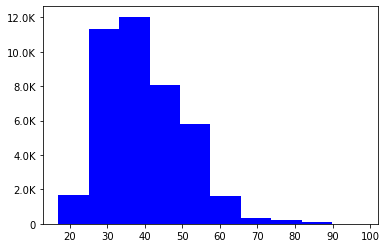

In [96]:
fig, ax = plt.subplots()
hist(ax, df.select('age'), bins = 10, color=['blue'])

In [102]:
def pie_chart(df, col):
    classes = df.groupBy(col).count().orderBy('count', ascending=False)
    pd_df = classes.toPandas()
    pd_df.plot(kind='pie', x=col, y='count', labels=pd_df[col], legend=False)
    plt.ylabel(None)
    plt.show()

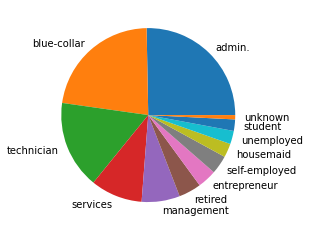

In [106]:
pie_chart(df, 'job')

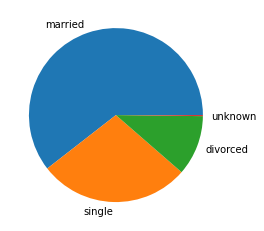

In [107]:
pie_chart(df, 'marital')

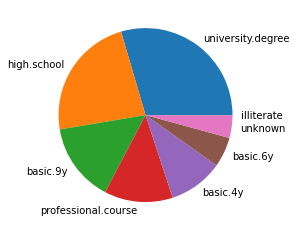

In [108]:
pie_chart(df, 'education')

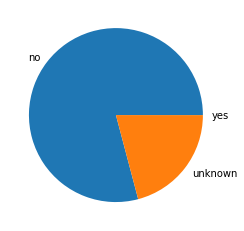

In [109]:
pie_chart(df, 'default')

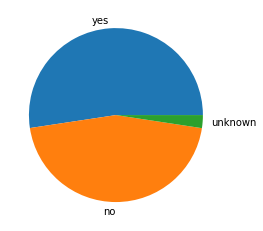

In [122]:
pie_chart(df, 'housing')

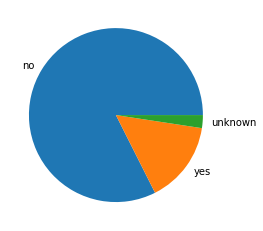

In [121]:
pie_chart(df, 'loan')

In [139]:
df.select(numeric_list).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934043,17,98
duration,41188,258.2850101971448,259.27924883646455,0,4918
campaign,41188,2.567592502670681,2.770013542902331,1,56
pdays,41188,962.4754540157328,186.910907344741,0,999
previous,41188,0.17296299893172767,0.49490107983928927,0,7


In [140]:
numeric_data = df.select(numeric_list).toPandas()

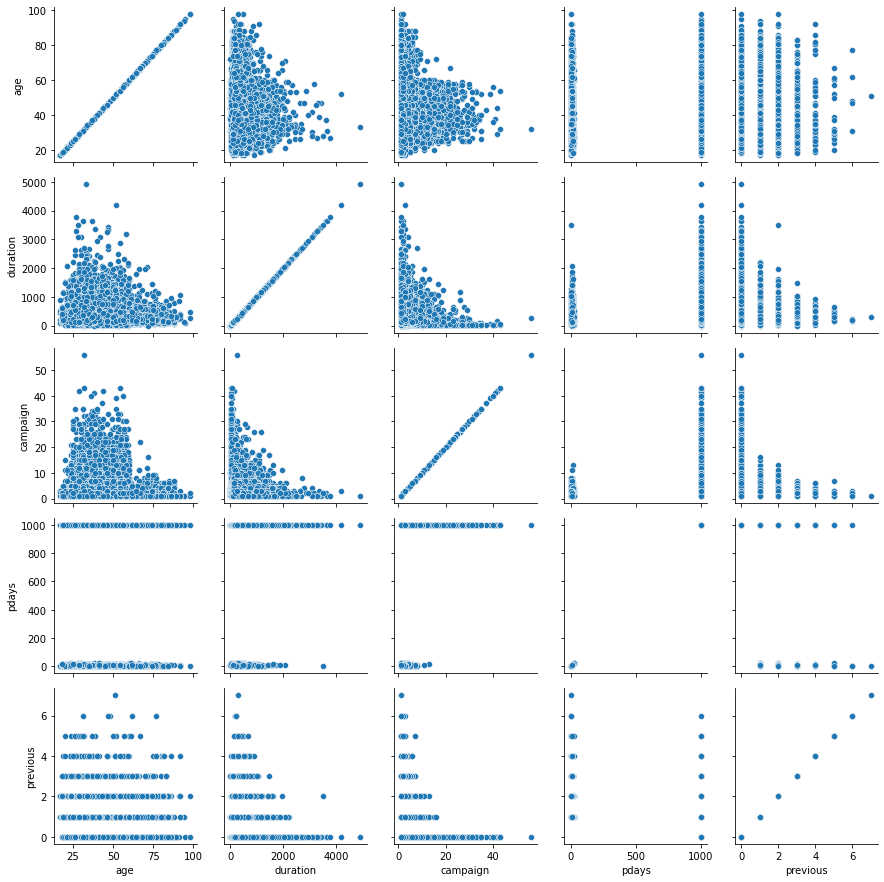

In [142]:
g = sns.PairGrid(numeric_data)
g.map(sns.scatterplot)

In [284]:
df.show(1)

+---+---------+-------+---------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---------+-------+---------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married| basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
+---+---------+-------+---------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
only showing top 1 r

### Modelling 

In [346]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import confusion_matrix

In [347]:
data = df.drop(*['month','day_of_week'])

In [348]:
data.show(1)

+---+---------+-------+---------+-------+-------+----+---------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|education|default|housing|loan|  contact|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---------+-------+---------+-------+-------+----+---------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married| basic.4y|     no|     no|  no|telephone|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
+---+---------+-------+---------+-------+-------+----+---------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
only showing top 1 row



In [349]:
#Preprocessing steps
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# create object of StringIndexer class and specify input and output column
Index_job = StringIndexer(inputCol='job',outputCol='job_Index')
Index_marital = StringIndexer(inputCol='marital',outputCol='marital_Index')
Index_education = StringIndexer(inputCol='education',outputCol='education_Index')
Index_default = StringIndexer(inputCol='default',outputCol='default_Index')
Index_housing = StringIndexer(inputCol='housing',outputCol='housing_Index')
Index_loan = StringIndexer(inputCol='loan',outputCol='loan_Index')
Index_contact = StringIndexer(inputCol='contact',outputCol='contact_Index')
Index_poutcome = StringIndexer(inputCol='poutcome',outputCol='poutcome_Index')
Index_y = StringIndexer(inputCol='y',outputCol='y_Index')


# transform the data
data = Index_job.fit(data).transform(data)
data = Index_marital.fit(data).transform(data)
data = Index_education.fit(data).transform(data)
data = Index_default.fit(data).transform(data)
data = Index_housing.fit(data).transform(data)
data = Index_loan.fit(data).transform(data)
data = Index_contact.fit(data).transform(data)
data = Index_poutcome.fit(data).transform(data)
data = Index_y.fit(data).transform(data)

In [350]:
# create object and specify input and output column
OHE = OneHotEncoder(inputCols=['job_Index', 'marital_Index','education_Index','default_Index','housing_Index','loan_Index','contact_Index', 'poutcome_Index','y_Index'],outputCols=['job_OHE', 'marital_OHE','education_OHE','default_OHE','housing_OHE','loan_OHE', 'contact_OHE','poutcome_OHE','y_OHE'])

# transform the data
my_data = OHE.fit(data).transform(data)

In [351]:
my_data.show(1)

+---+---------+-------+---------+-------+-------+----+---------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+--------------+-------+--------------+-------------+-------------+-------------+-------------+-------------+-----------+-------------+-------------+
|age|      job|marital|education|default|housing|loan|  contact|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|job_Index|marital_Index|education_Index|default_Index|housing_Index|loan_Index|contact_Index|poutcome_Index|y_Index|       job_OHE|  marital_OHE|education_OHE|  default_OHE|  housing_OHE|     loan_OHE|contact_OHE| poutcome_OHE|        y_OHE|
+---+---------+-------+---------+-------+-------+----+---------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-

In [352]:
df.show(1)

+---+---------+-------+---------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---------+-------+---------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married| basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
+---+---------+-------+---------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
only showing top 1 r

In [353]:
num_cols

['emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'age',
 'duration',
 'campaign',
 'pdays',
 'previous']

In [354]:
from pyspark.ml.feature import VectorAssembler

# specify the input and output columns of the vector assembler
assembler = VectorAssembler(inputCols=['age',
                                       'job_Index',
                                       'marital_Index',
                                       'education_Index',
                                       'default_Index',
                                       'housing_Index',
                                       'loan_Index',
                                       'contact_Index',
                                       'duration',
                                       'campaign',
                                       'pdays',
                                       'previous',
                                       'poutcome_Index',
                                       'emp_var_rate',
                                       'cons_price_idx',
                                       'cons_conf_idx',
                                       'euribor3m', 
                                       'nr_employed',
                                       'job_OHE',
                                       'marital_OHE',
                                       'education_OHE',
                                       'default_OHE',
                                       'housing_OHE',
                                       'loan_OHE',
                                       'contact_OHE',
                                       'poutcome_OHE'],
                           outputCol='features')


# transform the data
final_data = assembler.transform(my_data)

In [355]:
# view the transformed vector
final_data.select('features','y_Index').show()

+--------------------+-------+
|            features|y_Index|
+--------------------+-------+
|(48,[0,1,3,5,7,8,...|    0.0|
|(48,[0,1,3,4,5,7,...|    0.0|
|(48,[0,1,3,7,8,9,...|    0.0|
|(48,[0,3,5,7,8,9,...|    0.0|
|(48,[0,1,3,5,6,7,...|    0.0|
|(48,[0,1,3,4,5,7,...|    0.0|
|(48,[0,3,5,7,8,9,...|    0.0|
|(48,[0,1,3,4,5,7,...|    0.0|
|(48,[0,1,2,3,7,8,...|    0.0|
|(48,[0,1,2,3,7,8,...|    0.0|
|(48,[0,1,3,4,5,7,...|    0.0|
|(48,[0,1,2,3,7,8,...|    0.0|
|(48,[0,1,2,3,5,6,...|    0.0|
|(48,[0,1,2,3,7,8,...|    0.0|
|(48,[0,1,3,7,8,9,...|    0.0|
|(48,[0,1,3,4,6,7,...|    0.0|
|(48,[0,1,3,7,8,9,...|    0.0|
|(48,[0,1,3,4,6,7,...|    0.0|
|(48,[0,1,3,6,7,8,...|    0.0|
|(48,[0,1,2,3,4,5,...|    0.0|
+--------------------+-------+
only showing top 20 rows



In [356]:
#Model_Dataframe
model_df = final_data.select(['features','y_Index'])
model_df = model_df.withColumnRenamed("y_Index","label")
model_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [357]:
#Split into training & testing Dataframe
training_df,test_df = model_df.randomSplit([0.75,0.25])

In [358]:
#Create a logistic regression model object
from pyspark.ml.classification import LogisticRegression
log_reg=LogisticRegression().fit(training_df)

In [402]:
log_reg.save("lr")

Py4JJavaError: An error occurred while calling o12171.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:106)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1091)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1062)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1027)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1009)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1008)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:965)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:963)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1599)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1599)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1585)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1585)
	at org.apache.spark.ml.util.DefaultParamsWriter$.saveMetadata(ReadWrite.scala:413)
	at org.apache.spark.ml.classification.LogisticRegressionModel$LogisticRegressionModelWriter.saveImpl(LogisticRegression.scala:1316)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.lang.UnsatisfiedLinkError: 'boolean org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(java.lang.String, int)'
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:793)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1218)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1423)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:601)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:761)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.getAllCommittedTaskPaths(FileOutputCommitter.java:334)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJobInternal(FileOutputCommitter.java:404)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJob(FileOutputCommitter.java:377)
	at org.apache.hadoop.mapred.FileOutputCommitter.commitJob(FileOutputCommitter.java:136)
	at org.apache.hadoop.mapred.OutputCommitter.commitJob(OutputCommitter.java:291)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.commitJob(HadoopMapReduceCommitProtocol.scala:192)
	at org.apache.spark.internal.io.SparkHadoopWriter$.$anonfun$write$3(SparkHadoopWriter.scala:100)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.timeTakenMs(Utils.scala:642)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:100)
	... 51 more


In [359]:
lr_summary=log_reg.summary

In [360]:
#Overall accuracy of the classification model
lr_summary.accuracy

0.9117562056452908

In [361]:
#Area under ROC
lr_summary.areaUnderROC

0.9292835424954087

In [362]:
#Precision of both classes
print(lr_summary.precisionByLabel)

[0.9291645133505598, 0.6729678638941399]


In [363]:
#Get Preditions
predictions = log_reg.transform(test_df)

In [364]:
predictions.select('label','prediction').show(50)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|     

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_24664/3476057707.py:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


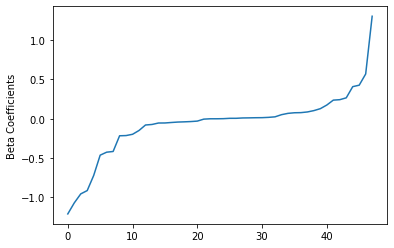

In [365]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(log_reg.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

Training set areaUnderROC: 0.9292835424954087


C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_24664/3703026547.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


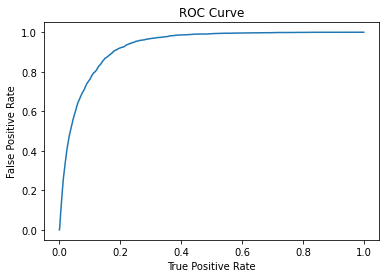

In [366]:
trainingSummary = log_reg.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [367]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9278187724805309


In [412]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(training_df)

In [413]:
pred = dtModel.transform(test_df)
pred.show(3)

+--------------------+-----+---------------+--------------------+----------+
|            features|label|  rawPrediction|         probability|prediction|
+--------------------+-----+---------------+--------------------+----------+
|(48,[0,1,2,3,4,5,...|  0.0|[24040.0,689.0]|[0.97213797565611...|       0.0|
|(48,[0,1,2,3,4,5,...|  0.0|[24040.0,689.0]|[0.97213797565611...|       0.0|
|(48,[0,1,2,3,4,5,...|  0.0|[24040.0,689.0]|[0.97213797565611...|       0.0|
+--------------------+-----+---------------+--------------------+----------+
only showing top 3 rows



In [414]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(pred)
 
print("Prediction Accuracy: ", acc)
 
y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Prediction Accuracy:  0.9076014693248544
Confusion Matrix:
[[8483  404]
 [ 506  654]]


In [415]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(pred, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.5308100169561893


In [416]:
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(maxIter=10, \
                 regParam=0.1, \
                 featuresCol="features", \
                 labelCol='label')
svmodel = lsvc.fit(training_df)

In [417]:
pred_sv = svmodel.transform (test_df)

In [418]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(pred_sv)
 
print("Prediction Accuracy: ", acc)
 
y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Prediction Accuracy:  0.8674322385375239
Confusion Matrix:
[[8483  404]
 [ 506  654]]


In [419]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(pred_sv, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9179743367879482


In [420]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1.0, \
                modelType="gaussian", \
                featuresCol="features", \
                labelCol='label')
model_nb = nb.fit(training_df)

In [421]:
pred_nb = model_nb.transform (test_df)

In [422]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(pred_nb)
 
print("Prediction Accuracy: ", acc)
 
y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Prediction Accuracy:  0.8427972914283859
Confusion Matrix:
[[8483  404]
 [ 506  654]]


In [423]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(pred_nb, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.5754602809993679


In [424]:
from pyspark.ml.classification import RandomForestClassifier
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol='label', \
                            featuresCol="features", \
                            numTrees=50)
model_rf = rf.fit(training_df)

In [425]:
pred_rf = model_rf.transform (test_df)

In [426]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(pred_rf)
 
print("Prediction Accuracy: ", acc)
 
y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Prediction Accuracy:  0.8693049624999294
Confusion Matrix:
[[8483  404]
 [ 506  654]]


In [427]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(pred_rf, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9251439530038065


In [382]:
featureImportances= model_rf.featureImportances.toArray()

In [383]:
featureImportances

array([8.01523760e-03, 1.72431228e-03, 3.64211206e-04, 1.30397787e-03,
       1.96106838e-03, 1.25227654e-04, 6.16290307e-05, 8.80833233e-03,
       2.84511449e-01, 1.77228097e-03, 9.70656059e-02, 1.89583765e-02,
       2.32151283e-02, 1.03024698e-01, 5.48975884e-02, 6.04360752e-02,
       1.06427362e-01, 1.73176919e-01, 2.17586063e-04, 2.74577591e-03,
       1.73869994e-04, 2.87188999e-04, 2.24376648e-04, 6.04139891e-04,
       1.05851334e-04, 1.14927464e-04, 2.86955225e-04, 3.14189160e-04,
       1.44446366e-03, 1.45230984e-04, 2.96317166e-04, 9.25631044e-05,
       7.90584119e-04, 5.27103756e-06, 2.91345120e-04, 4.81204302e-04,
       2.25438762e-04, 2.36227356e-04, 2.19629172e-04, 1.53043520e-03,
       1.97982590e-03, 2.74215364e-04, 1.28896041e-04, 3.08458437e-04,
       2.63427935e-04, 8.01757435e-03, 1.49429074e-02, 1.74016445e-02])

In [386]:
model_rf.featureImportances

SparseVector(48, {0: 0.008, 1: 0.0017, 2: 0.0004, 3: 0.0013, 4: 0.002, 5: 0.0001, 6: 0.0001, 7: 0.0088, 8: 0.2845, 9: 0.0018, 10: 0.0971, 11: 0.019, 12: 0.0232, 13: 0.103, 14: 0.0549, 15: 0.0604, 16: 0.1064, 17: 0.1732, 18: 0.0002, 19: 0.0027, 20: 0.0002, 21: 0.0003, 22: 0.0002, 23: 0.0006, 24: 0.0001, 25: 0.0001, 26: 0.0003, 27: 0.0003, 28: 0.0014, 29: 0.0001, 30: 0.0003, 31: 0.0001, 32: 0.0008, 33: 0.0, 34: 0.0003, 35: 0.0005, 36: 0.0002, 37: 0.0002, 38: 0.0002, 39: 0.0015, 40: 0.002, 41: 0.0003, 42: 0.0001, 43: 0.0003, 44: 0.0003, 45: 0.008, 46: 0.0149, 47: 0.0174})

### Kmeans

In [318]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(final_data)
data_scale_output=data_scale.transform(final_data)
data_scale_output.show(2)

+---+---------+-------+-----------+-------+-------+----+---------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+--------------+-------+--------------+-------------+-------------+-------------+-------------+-------------+-----------+-------------+-------------+--------------------+--------------------+
|age|      job|marital|  education|default|housing|loan|  contact|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|job_Index|marital_Index|education_Index|default_Index|housing_Index|loan_Index|contact_Index|poutcome_Index|y_Index|       job_OHE|  marital_OHE|education_OHE|  default_OHE|  housing_OHE|     loan_OHE|contact_OHE| poutcome_OHE|        y_OHE|            features|        standardized|
+---+---------+-------+-----------+-------+-------+----+---------+--------

In [319]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.2195122027629242
Silhouette Score: 0.22106431665550488
Silhouette Score: 0.1695514491249948
Silhouette Score: 0.14816139444226242
Silhouette Score: 0.1280218670426926
Silhouette Score: 0.12962751709387
Silhouette Score: 0.1327392146775022
Silhouette Score: 0.18882988300610948


Text(0, 0.5, 'cost')

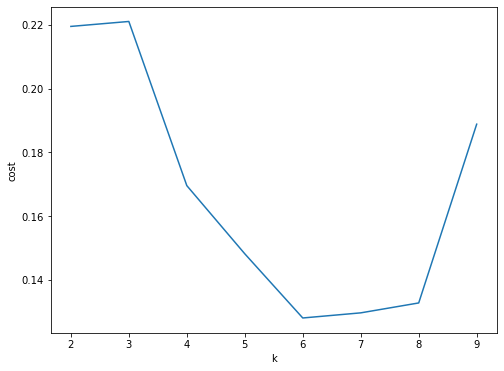

In [320]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("cost")